**The goal of this project was to better understand COVID transmissions in two aspects. There are two datasets available from the aggregate COVID data of C3.AI Data Lake. One is a qualitative survey data and the other is a quantitative time series mobility data.**

1. **Survey Data**
- Data will consist of COVID-19-related public opinion, demographic, and symptom prevalence. Upon observing the results of A4, a deep dive into survey data on mask mandate would support the human centered aspect of understanding how people responded to these types of policy changes in and around Harris County.
- Questions that came to mind regarding this aspect of my analysis are the following:
    - Is there more to the mask mandate than its policy execution period? 
    - How many seem like they will comply more with the mask mandate or any other important mandates to curb transmission rates?
    - Does their level of COVID concern affect how much they are willing to follow through on certain policies?
    - Is their level of COVID concern affeted by education levels, employment status, or other demographics?


2. **Mobility Data** 
- We tried to see initially if there was a direct relation between mask mandates and infection rates but are there other factors here that can be looked into. I chose to look into mobility which is interesting because it gives us an idea of travel and movement to and from the county. This could link to transmission coming from outside the county or vice versa. The available Google and Apple mobility data is quite comprehensive. 
- Questions that came to mind regarding this aspect of my analysis are the following:
    - Is there a correlation between covid cases over time and mobility? 
    - Are the number of cases varying for different kinds of mobility - walking, public transit, etc. ? 
    - Did travel restrictions from city to city help reduce covid alongside observing mask mandates?

In [216]:
import csv
import datetime
import re
from functools import partial

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats

from matplotlib.patches import Patch


%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 7)

Import Python API used to fetch C3.AI data.

- The data provided in this repository is made available for public, non-commercial use by Swayable in partnership with TapResearch. The data includes symptom prevalence, demographic and political opinion data collected from thousands of respondents since April, 2020.

In [309]:
import c3aidatalake

# 1. Survey Data Analysis

## Preprocessing and Exploring the Data

Fetch participants who are located in Texas using the C3.AI Data Lake API.

**IMPORTANT NOTE: Initially the data was filtered in the default API config with `coronavirusIntent_Mask >= 75` which I later corrected to not include that filter. I performed my analysis again with the new data points and found mostly similar results. Hence instead of `1,483` data points I now have `2,598` data points instead. The results I show now may not be the same as presented but agree with the same findings.** 

In [359]:

# survey = c3aidatalake.fetch(
#     "surveydata",
#     {
#         "spec": {
#             "filter": "location == 'Texas_UnitedStates' && coronavirusIntent_Mask >= 75" #Mistake
#         }
#     },
#     get_all = True
# )

survey = c3aidatalake.fetch(
    "surveydata",
    {
        "spec": {
            "filter": "location == 'Texas_UnitedStates'"
        }
    },
    get_all = True
)

survey

,id,birthYear2020,coronavirusConcern,coronavirusEmployment,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusLocalCommunity,coronavirusSupportSystem,...,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,location.id,annualHouseholdIncome
0,000279c1666d8f838cbf9573b25e943d,1991,4.4,was-full,42.0,61.0,43.0,59.0,0.0,no-one,...,False,False,False,False,True,False,False,True,Texas_UnitedStates,NaN
1,00078a37abcdaa096a7572a406844d93,1994,7.6,now-jobless,74.0,72.0,85.0,72.0,1.0,no-one,...,True,False,False,True,False,True,False,False,Texas_UnitedStates,10000.0
2,0018edaa0eea41b279f993438c51873b,1992,8.9,was-full,83.0,52.0,97.0,50.0,0.0,no-one,...,False,False,False,True,False,False,True,False,Texas_UnitedStates,NaN
3,003926cb2a5f416c55e8c54e83a8881f,1957,10.0,was-disabled,100.0,100.0,100.0,100.0,10.0,fam-friend,...,True,True,False,True,False,True,False,False,Texas_UnitedStates,NaN
4,00450d859e1e0d5a23b3267254fe209b,1999,2.3,now-part,94.0,96.0,97.0,87.0,1.0,fam-friend,...,True,False,False,False,True,False,False,True,Texas_UnitedStates,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,ff7dce12ce20d8d659cc51503f23bf32,1990,1.8,was-jobless,NaN,100.0,100.0,100.0,0.0,state-gov,...,True,False,False,True,False,True,False,False,Texas_UnitedStates,29000.0
594,ff91974f7407c21ddf25c62086dee1c6,2001,10.0,"was-full, was-part",92.0,98.0,100.0,30.0,0.0,"religious, no-one, other, fedgov, local-gov",...,False,False,False,False,True,False,False,True,Texas_UnitedStates,NaN
595,ffad5f5b21e87b6e821a710a83ed52ed,1999,3.1,now-part,100.0,0.0,52.0,100.0,4.0,no-one,...,True,False,False,True,False,False,True,True,Texas_UnitedStates,84000.0
596,ffc9a694007b4455c90f891e9d43be6e,2002,0.8,"was-full, was-disabled",25.0,62.0,28.0,91.0,0.0,"fam-friend, local-gov, state-gov, fedgov",...,False,False,True,False,True,True,False,False,Texas_UnitedStates,55050.0


In [356]:
survey.columns

Index(['id', 'birthYear2020', 'coronavirusConcern', 'coronavirusEmployment',
       'coronavirusIntent_Mask', 'coronavirusIntent_SixFeet',
       'coronavirusIntent_StayHome', 'coronavirusIntent_WashHands',
       'coronavirusLocalCommunity', 'coronavirusSupportSystem',
       'coronavirusSymptoms', 'ratioOfAdultHospitalization',
       'coronavirusWhenShouldReopen', 'education', 'ethnicity', 'gender',
       'hasCoronavirusBelief', 'politicalBelief', 'politicalParty', 'religion',
       'religiosity', 'trumpApproval', 'zipcodePrefix', 'startTime',
       'coronaSimilarFlu', 'coronaOnlyElderly', 'youngInvulnerable',
       'elderlyMoreRisk', 'coronaAllHospitalize', 'coronaKillsMost',
       'ethnicitySpreadsCovid', 'allSpreadCovid', 'nonNativesSpreadCovid',
       'asymptomaticSpread', 'onlySickSpread', 'infectFromAnimal',
       'location.id', 'annualHouseholdIncome'],
      dtype='object')

Reorganizing columns for separate analysis.

In [314]:
details_cols = ['id','birthYear2020', 'coronavirusEmployment', 'education', 'ethnicity', 'gender',
       'hasCoronavirusBelief', 'politicalBelief', 'politicalParty', 'religion',
       'religiosity', 'trumpApproval', 'zipcodePrefix', 'startTime', 'location.id', 'annualHouseholdIncome'] 
cov_policies_cols = ['id','coronavirusIntent_Mask', 'coronavirusIntent_SixFeet', 'coronavirusIntent_StayHome', 'coronavirusIntent_WashHands', 'coronavirusSymptoms']
cov_beliefs_cols = ['id','coronaSimilarFlu', 'coronaOnlyElderly', 'youngInvulnerable',
       'elderlyMoreRisk', 'coronaAllHospitalize', 'coronaKillsMost',
       'ethnicitySpreadsCovid', 'allSpreadCovid', 'nonNativesSpreadCovid',
       'asymptomaticSpread', 'onlySickSpread', 'infectFromAnimal'] #multi-regr

cov_concern_col = ['id','coronavirusConcern'] 

Looking at distibution of coronavirusConcern.

Text(0.5, 1.0, 'Coronavirus Concern Distribution (0-10)')

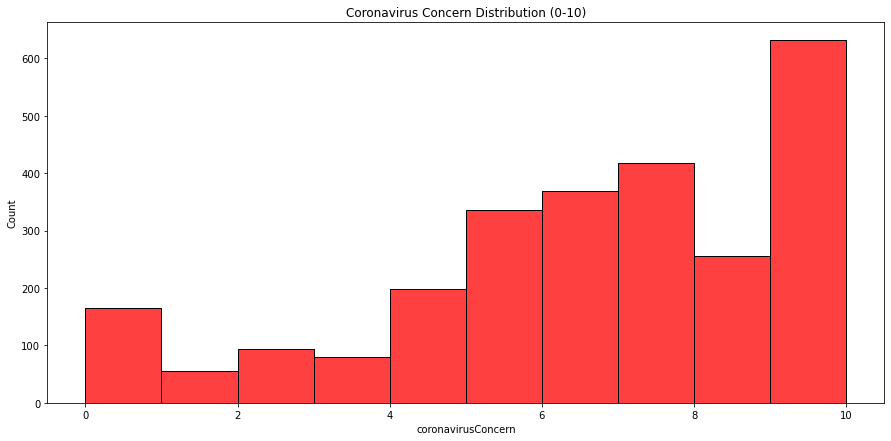

In [367]:
sns.histplot(survey.coronavirusConcern, color='red', bins=10).set_title("Coronavirus Concern Distribution (0-10)")

*The distribution seems left-skewed showing more people being concerned with coronavirus.*

Text(0.5, 1.0, 'Politial Party, 0=Strongly Democrat and 10=Strongly Republican ')

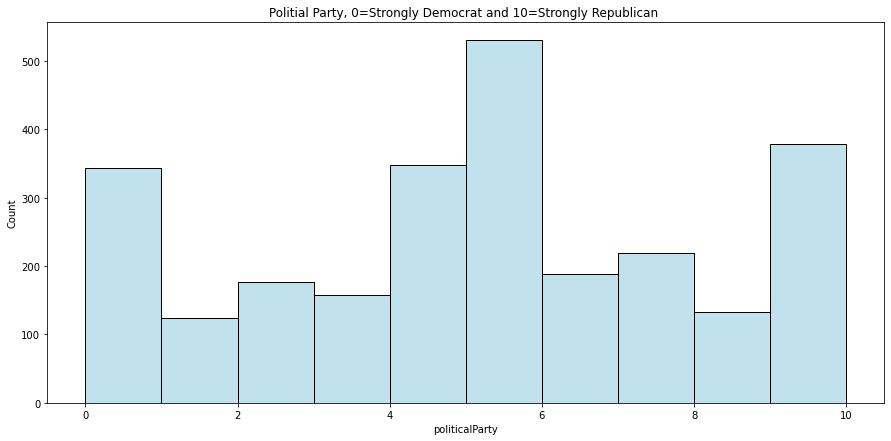

In [372]:
sns.histplot(survey.politicalParty, color='lightblue', bins=10).set_title("Politial Party, 0=Strongly Democrat and 10=Strongly Republican ")

The following is the distribution regarding Trump Approval Ratings.

Text(0.5, 1.0, 'Trump Approval Ratings Distribution')

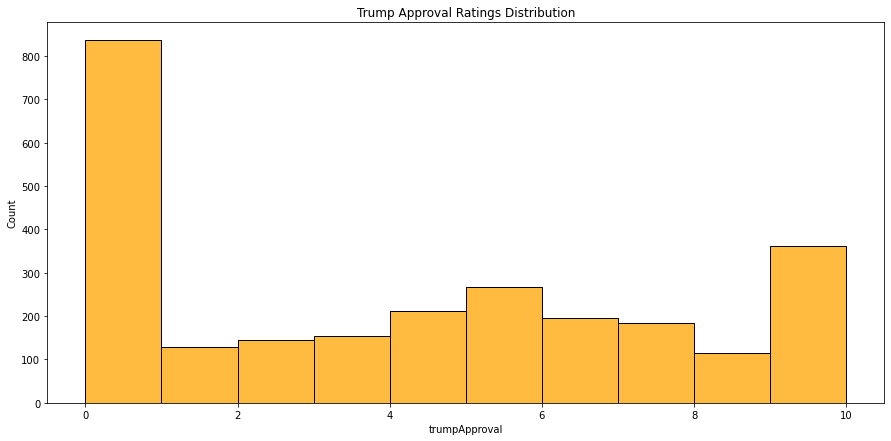

In [316]:
# survey.trumpApproval.hist()
sns.histplot(survey.trumpApproval, color='orange', bins=10).set_title("Trump Approval Ratings Distribution")

*It's interesting to observe the low Trump Approval Ratings for this state - Texas - which is predominantly right. Political bias plays an important role in issues that can be made political like trusting certain government policies. Therefore, it's important to have this information to judge the political incline of this crowd which may be the result of selective sampling or bias in the data.*

# Research Question 1 

## Is `coronavirusConcern` directly related to Education Levels, Employment Status or Intent of following covid policies,  myths and beliefs about Covid?


First let's look at `coronovirusConcern` based on intent to wear masks (`coronavirusIntent_Mask`). First we observe a scatter plot of the two to see if there is any relation or grouping that we can see visually.

Text(0, 0.5, 'masking intent')

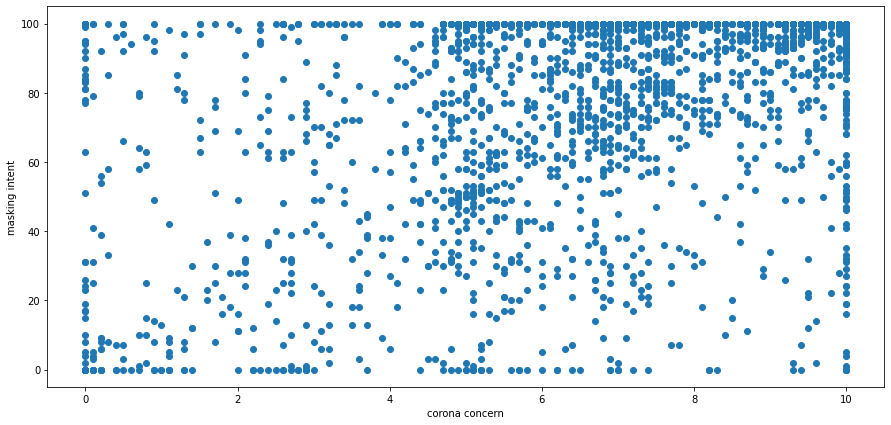

In [360]:
data = survey[['id', 'coronavirusConcern', 'coronavirusIntent_Mask']]
plt.scatter(data.coronavirusConcern, data.coronavirusIntent_Mask)
plt.xlabel("corona concern")
plt.ylabel("masking intent")

*Doesn't show that there is a linear relation here but shows that people with more intent to mask had higher concern regarding covid. We could look at other variables as well to see if the same relation persists.*

**Now getting into answering our hypothesis let's look at coronavirus concern with different types of data that may have an influence on concern. Looking at:**

1. Education Level
2. Employment Status
3. Measure of intent to follow basic policies.

## A. Coronavirus concern and education.


Participant's self-reported education background. Allowed values:
- school: Some School / No Diploma,
- highschool: High School Graduate,
- some-college: Some College,
- college: College Degree,
- postgrad: Postgraduate Degree.

In [318]:
adf = survey[['id', 'coronavirusEmployment', 'education', 'coronavirusConcern']]
adf

,id,coronavirusEmployment,education,coronavirusConcern
0,000279c1666d8f838cbf9573b25e943d,was-full,some-college,4.4
1,00078a37abcdaa096a7572a406844d93,now-jobless,college,7.6
2,0018edaa0eea41b279f993438c51873b,was-full,postgrad,8.9
3,003926cb2a5f416c55e8c54e83a8881f,was-disabled,highschool,10.0
4,00450d859e1e0d5a23b3267254fe209b,now-part,highschool,2.3
...,...,...,...,...
593,ff7dce12ce20d8d659cc51503f23bf32,was-jobless,highschool,1.8
594,ff91974f7407c21ddf25c62086dee1c6,"was-full, was-part",college,10.0
595,ffad5f5b21e87b6e821a710a83ed52ed,now-part,some-college,3.1
596,ffc9a694007b4455c90f891e9d43be6e,"was-full, was-disabled",highschool,0.8


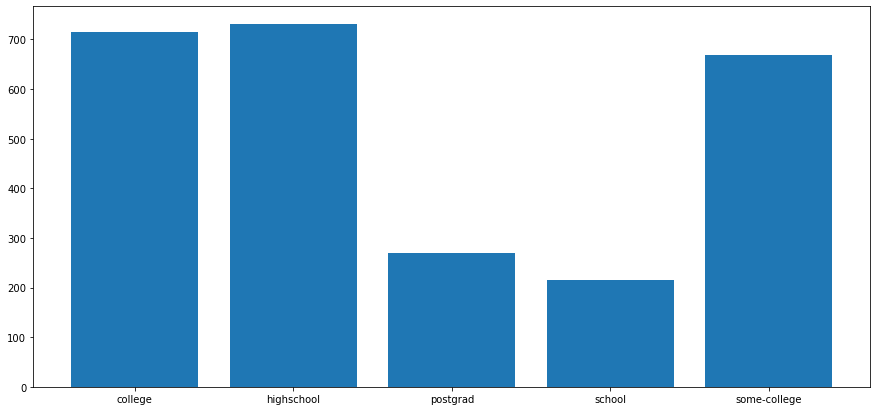

In [319]:
#plotting distirbution of education
labels, counts = np.unique(np.array(adf.education), return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

[Text(0.5, 1.0, 'Covid Concern distribution for Varying Levels of Education.')]

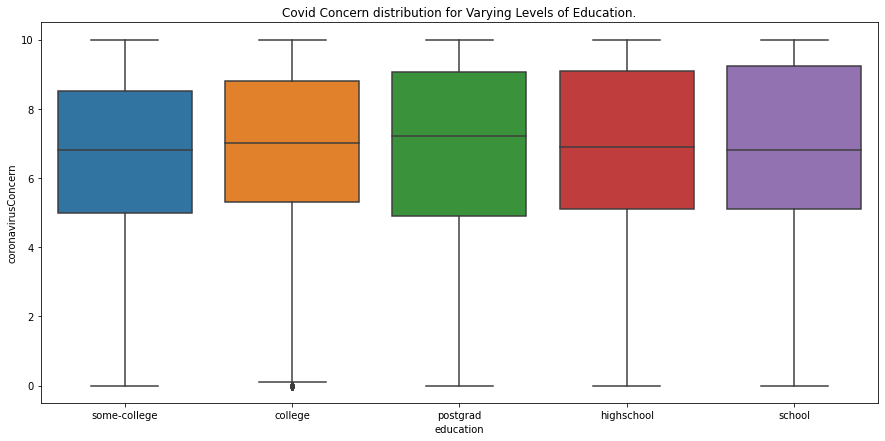

In [320]:
sns.boxplot(data=adf, x='education', y='coronavirusConcern').set(title='Covid Concern distribution for Varying Levels of Education.')

*From the boxplots we can see that the means don't vary too much between the different types of education levels and hence cannot proceed further thinking that level of education is in an indicator of coronavirus concern.*

Let's look at the distributions of each education level to see if we meet assumption to perfom an ANOVA test to establish that there is no significant difference between the means of each category.

In [321]:
adf.education.value_counts()

highschool      730
college         714
some-college    669
postgrad        270
school          215
Name: education, dtype: int64

In [322]:
#perform the one-way ANOVA test
fvalue, pvalue = stats.f_oneway(adf.coronavirusConcern[adf.education=='college'],
                                adf.coronavirusConcern[adf.education=='highschool'],
                                adf.coronavirusConcern[adf.education=='some-college'],
                                adf.coronavirusConcern[adf.education=='postgrad'],
                                adf.coronavirusConcern[adf.education=='school'])
print(fvalue, pvalue)

0.9716633902255265 0.421759530065117


*The high p-value shows that we can't reject the null hypothesis that there is no significant difference between the means of each category.*

This data isn't normally distributed so I decided to check with a non-parametric test for the same hypothesis and performed a Kruskal-Wallis test.

In [323]:
#perform Kruskal-Wallis Test 
stats.kruskal(adf.coronavirusConcern[adf.education=='college'],
                                adf.coronavirusConcern[adf.education=='highschool'],
                                adf.coronavirusConcern[adf.education=='some-college'],
                                adf.coronavirusConcern[adf.education=='postgrad'],
                                adf.coronavirusConcern[adf.education=='school'])

KruskalResult(statistic=6.072417196806048, pvalue=0.1938049936544777)

*Arrived at the same result. The high p-value shows that we can't reject the null hypothesis that there is no significant difference between the means of each category.*

**Coronavirus Concern was independent of Education Level.**

## B. Coronavirus concern and Employment.


Participant's response to the question: How has your employment status changed since January 1, 2020? The value of this field is a comma-separated string consisting one or more of the following choices:
- was-full: I was employed full-time on January 1, 2020.
- was-part: I was employed part-time on January 1, 2020.
- was-jobless: I was unemployed on January 1, 2020.
- now-full: I am now employed full-time.
- now-part: I am now employed part-time.
- now-jobless: I am now unemployed.
- now-retired: I am now retired.
- was-retired: I was retired on January 1, 2020.
- was-disabled: I was disabled and unable to work on January 1, 2020.
- now-disabled: I am now disabled and unable to work.

The employemnt status was a list of different statuses that the survey participant went through. Therefore, I had to parse this list and take the last entry as the latest employment status for the respective participant.

In [324]:
employment_df = survey.copy()
employment_df["coronavirusEmployment"] = employment_df["coronavirusEmployment"].str.split(", ")
employment_df = employment_df.explode("coronavirusEmployment")
employment_df = employment_df.groupby(["id"]).agg("last")[["coronavirusEmployment","coronavirusConcern"]].reset_index()
employment_df

,id,coronavirusEmployment,coronavirusConcern
0,000279c1666d8f838cbf9573b25e943d,was-full,4.4
1,00078a37abcdaa096a7572a406844d93,now-jobless,7.6
2,0018edaa0eea41b279f993438c51873b,was-full,8.9
3,003926cb2a5f416c55e8c54e83a8881f,was-disabled,10.0
4,00450d859e1e0d5a23b3267254fe209b,now-part,2.3
...,...,...,...
2593,ff7dce12ce20d8d659cc51503f23bf32,was-jobless,1.8
2594,ff91974f7407c21ddf25c62086dee1c6,was-part,10.0
2595,ffad5f5b21e87b6e821a710a83ed52ed,now-part,3.1
2596,ffc9a694007b4455c90f891e9d43be6e,was-disabled,0.8


Let's look at the distribution of coronavirus concern for this case of employment status.

[Text(0.5, 1.0, 'Covid Concern distribution for Different Employemnt Status.')]

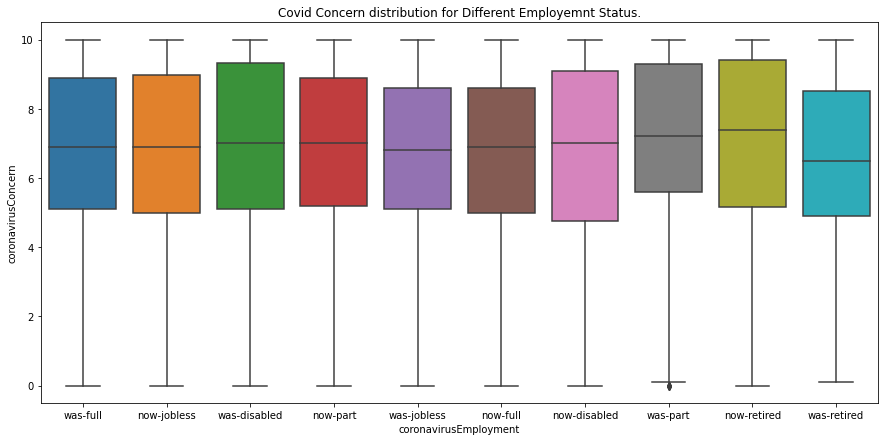

In [325]:
sns.boxplot(data=employment_df, x='coronavirusEmployment', y='coronavirusConcern').set(title='Covid Concern distribution for Different Employemnt Status.')

*From the boxplots we can see that the means don't vary too much between the different types of education levels and hence cannot proceed further thinking that level of education is in an indicator of coronavirus concern.*

In [326]:
employment_df.coronavirusEmployment.value_counts() #might need downsampled - remove was-retired

was-full        592
now-full        420
now-jobless     414
was-jobless     257
was-part        244
now-part        241
now-disabled    171
was-disabled    100
now-retired      94
was-retired      65
Name: coronavirusEmployment, dtype: int64

I went ahead and performed a non-parametric Kruskal-Wallis test to compare the means of these categories in job status due to the dat not having satisfied all the assumptions to perform an ANOVA.

In [361]:
#perform the one-way ANOVA test
fvalue, pvalue = stats.kruskal(employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='was-full'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='now-full'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='now-jobless'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='was-part'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='now-part'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='was-jobless'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='now-disabled'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='now-retired'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='was-disabled'],
                                employment_df.coronavirusConcern[employment_df.coronavirusEmployment =='was-retired'])
print(fvalue, pvalue)

12.202604172273492 0.20212697279368688


*The high p-value shows that we can't reject the null hypothesis that there is no significant difference between the means of each category.*

**Coronavirus Concern was independent of Employment Status.**

## C. Coronavirus concern and Intent to follow policies.


In [330]:
bdf = survey[['id','coronavirusIntent_Mask', 'coronavirusIntent_SixFeet', 'coronavirusIntent_StayHome', 'coronavirusIntent_WashHands', 'coronavirusConcern']]
bdf

,id,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusConcern
0,000279c1666d8f838cbf9573b25e943d,42.0,61.0,43.0,59.0,4.4
1,00078a37abcdaa096a7572a406844d93,74.0,72.0,85.0,72.0,7.6
2,0018edaa0eea41b279f993438c51873b,83.0,52.0,97.0,50.0,8.9
3,003926cb2a5f416c55e8c54e83a8881f,100.0,100.0,100.0,100.0,10.0
4,00450d859e1e0d5a23b3267254fe209b,94.0,96.0,97.0,87.0,2.3
...,...,...,...,...,...,...
593,ff7dce12ce20d8d659cc51503f23bf32,NaN,100.0,100.0,100.0,1.8
594,ff91974f7407c21ddf25c62086dee1c6,92.0,98.0,100.0,30.0,10.0
595,ffad5f5b21e87b6e821a710a83ed52ed,100.0,0.0,52.0,100.0,3.1
596,ffc9a694007b4455c90f891e9d43be6e,25.0,62.0,28.0,91.0,0.8


In [331]:
bdf.corr()

,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusConcern
coronavirusIntent_Mask,1.000000,0.609590,0.600296,0.446135,0.489919
coronavirusIntent_SixFeet,0.609590,1.000000,0.645384,0.527298,0.423462
coronavirusIntent_StayHome,0.600296,0.645384,1.000000,0.482450,0.474108
coronavirusIntent_WashHands,0.446135,0.527298,0.482450,1.000000,0.296989
coronavirusConcern,0.489919,0.423462,0.474108,0.296989,1.000000


In [337]:
bdf = bdf.dropna()
bdf

,id,coronavirusIntent_Mask,coronavirusIntent_SixFeet,coronavirusIntent_StayHome,coronavirusIntent_WashHands,coronavirusConcern
0,000279c1666d8f838cbf9573b25e943d,42.0,61.0,43.0,59.0,4.4
1,00078a37abcdaa096a7572a406844d93,74.0,72.0,85.0,72.0,7.6
2,0018edaa0eea41b279f993438c51873b,83.0,52.0,97.0,50.0,8.9
3,003926cb2a5f416c55e8c54e83a8881f,100.0,100.0,100.0,100.0,10.0
4,00450d859e1e0d5a23b3267254fe209b,94.0,96.0,97.0,87.0,2.3
...,...,...,...,...,...,...
592,ff68e6d8da9cf9a8f433c8417cf323b7,96.0,98.0,100.0,96.0,6.8
594,ff91974f7407c21ddf25c62086dee1c6,92.0,98.0,100.0,30.0,10.0
595,ffad5f5b21e87b6e821a710a83ed52ed,100.0,0.0,52.0,100.0,3.1
596,ffc9a694007b4455c90f891e9d43be6e,25.0,62.0,28.0,91.0,0.8


In [338]:
scaler1 = StandardScaler()
scaled_bdf = scaler1.fit_transform(bdf.iloc[:,1:])
scaled_bdf = pd.DataFrame(scaled_bdf, columns = bdf.columns[1:])

X = scaled_bdf.iloc[:,:-1]
y = scaled_bdf.coronavirusConcern.values

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     246.6
Date:                Thu, 09 Dec 2021   Prob (F-statistic):          2.23e-176
Time:                        20:22:39   Log-Likelihood:                -2853.8
No. Observations:                2301   AIC:                             5718.
Df Residuals:                    2296   BIC:                             5746.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

*Mask, SixFeet and StayHome intent significantly affect the levels of COVID concern among this population.*

***Full intent on wearing a mask, staying six feet and washing hands together implies a factor of 5.3 increase in rating for coronavirus concern.***

## D. Coronavirus concern and myths and beliefs


Exploring coronavirus concern with myths and beliefs.

### Use multi regression after converting to one-hot

In [339]:
cov_beliefs_cols = ['id','coronaSimilarFlu', 'coronaOnlyElderly', 'youngInvulnerable',
       'elderlyMoreRisk', 'coronaAllHospitalize', 'coronaKillsMost',
       'ethnicitySpreadsCovid', 'allSpreadCovid', 'nonNativesSpreadCovid',
       'asymptomaticSpread', 'onlySickSpread', 'infectFromAnimal']

cdf = survey[cov_beliefs_cols + ['coronavirusConcern']]
cdf

,id,coronaSimilarFlu,coronaOnlyElderly,youngInvulnerable,elderlyMoreRisk,coronaAllHospitalize,coronaKillsMost,ethnicitySpreadsCovid,allSpreadCovid,nonNativesSpreadCovid,asymptomaticSpread,onlySickSpread,infectFromAnimal,coronavirusConcern
0,000279c1666d8f838cbf9573b25e943d,False,False,False,True,False,False,False,False,True,False,False,True,4.4
1,00078a37abcdaa096a7572a406844d93,False,False,False,False,True,False,False,True,False,True,False,False,7.6
2,0018edaa0eea41b279f993438c51873b,False,False,False,False,False,False,False,True,False,False,True,False,8.9
3,003926cb2a5f416c55e8c54e83a8881f,False,False,False,True,True,True,False,True,False,True,False,False,10.0
4,00450d859e1e0d5a23b3267254fe209b,False,False,False,False,True,False,False,False,True,False,False,True,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,ff7dce12ce20d8d659cc51503f23bf32,True,False,True,True,True,False,False,True,False,True,False,False,1.8
594,ff91974f7407c21ddf25c62086dee1c6,False,False,False,False,False,False,False,False,True,False,False,True,10.0
595,ffad5f5b21e87b6e821a710a83ed52ed,False,False,False,False,True,False,False,True,False,False,True,True,3.1
596,ffc9a694007b4455c90f891e9d43be6e,True,False,False,True,False,False,True,False,True,True,False,False,0.8


In [340]:
scaler1 = StandardScaler()
scaled_cdf = scaler1.fit_transform(cdf.iloc[:,1:])
scaled_cdf = pd.DataFrame(scaled_cdf, columns = cdf.columns[1:])

X = scaled_cdf.iloc[:,1:-1]
y = scaled_cdf.iloc[:,-1]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:     coronavirusConcern   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     8.718
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           2.36e-15
Time:                        20:23:13   Log-Likelihood:                -3639.1
No. Observations:                2598   AIC:                             7302.
Df Residuals:                    2586   BIC:                             7373.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.776e-

Didn't explore these results fully. Need to interpret these findings still.

*FUTURE WORK: I want to see if the proportions of responses to each of these fields is related with the COVID Concern filed using statistical analysis. The Chi-square test is a good way to measure these proportions to see if there is any relationship between various fields and COVID Concern. This could help confirm the hypothesis that more concerned people would generally follow all advised protocols.*

# 2. Mobility Data Analysis

## Preprocessing and Exploring Data

### Extract overlapping timestamps - Remove nulls - ARIMA/Regression

In [341]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

locations = [
#     "Bexar_Texas_UnitedStates",
    "Harris_Texas_UnitedStates",
]

metrics = [
    "JHU_ConfirmedCases",
#     "JHU_ConfirmedDeaths",
    "Apple_TransitMobility",
    "Apple_WalkingMobility", 
    "Apple_DrivingMobility",
    "Google_ParksMobility",
    "Google_ResidentialMobility",
    "Google_GroceryMobility",
    "Google_TransitStationsMobility",
    "Google_RetailMobility",
    "Google_WorkplacesMobility"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries

,dates,Harris_Texas_UnitedStates.JHU_ConfirmedCases.data,Harris_Texas_UnitedStates.JHU_ConfirmedCases.missing,Harris_Texas_UnitedStates.Apple_WalkingMobility.data,Harris_Texas_UnitedStates.Apple_WalkingMobility.missing,Harris_Texas_UnitedStates.Apple_TransitMobility.data,Harris_Texas_UnitedStates.Apple_TransitMobility.missing,Harris_Texas_UnitedStates.Apple_DrivingMobility.data,Harris_Texas_UnitedStates.Apple_DrivingMobility.missing,Harris_Texas_UnitedStates.Google_ResidentialMobility.data,...,Harris_Texas_UnitedStates.Google_GroceryMobility.data,Harris_Texas_UnitedStates.Google_GroceryMobility.missing,Harris_Texas_UnitedStates.Google_TransitStationsMobility.data,Harris_Texas_UnitedStates.Google_TransitStationsMobility.missing,Harris_Texas_UnitedStates.Google_ParksMobility.data,Harris_Texas_UnitedStates.Google_ParksMobility.missing,Harris_Texas_UnitedStates.Google_WorkplacesMobility.data,Harris_Texas_UnitedStates.Google_WorkplacesMobility.missing,Harris_Texas_UnitedStates.Google_RetailMobility.data,Harris_Texas_UnitedStates.Google_RetailMobility.missing
0,2020-02-15,0.0,0,148.69,0,92.15,0,124.75,0,99.0,...,102.0,0,100.0,0,113.0,0,102.0,0,103.0,0
0,2020-02-16,0.0,0,97.33,0,76.64,0,90.11,0,99.0,...,101.0,0,98.0,0,116.0,0,100.0,0,106.0,0
0,2020-02-17,0.0,0,101.37,0,96.35,0,102.31,0,103.0,...,102.0,0,97.0,0,127.0,0,87.0,0,106.0,0
0,2020-02-18,0.0,0,98.58,0,99.23,0,105.75,0,100.0,...,101.0,0,103.0,0,112.0,0,102.0,0,102.0,0
0,2020-02-19,0.0,0,97.99,0,98.72,0,105.89,0,100.0,...,101.0,0,101.0,0,107.0,0,103.0,0,101.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2021-11-27,585483.0,0,0.0,100,0.0,100,0.0,100,0.0,...,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100
0,2021-11-28,585483.0,0,0.0,100,0.0,100,0.0,100,0.0,...,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100
0,2021-11-29,585480.0,0,0.0,100,0.0,100,0.0,100,0.0,...,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100
0,2021-11-30,585792.0,0,0.0,100,0.0,100,0.0,100,0.0,...,0.0,100,0.0,100,0.0,100,0.0,100,0.0,100


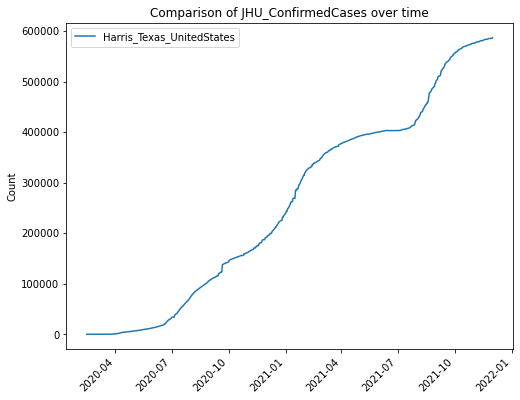

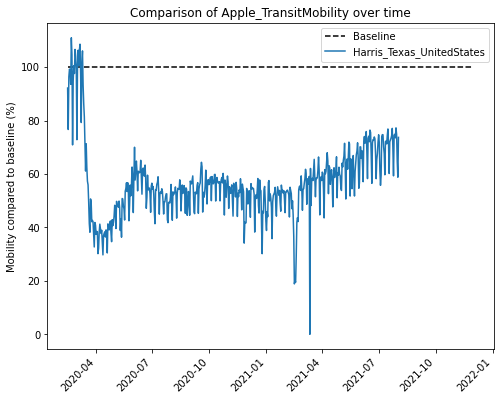

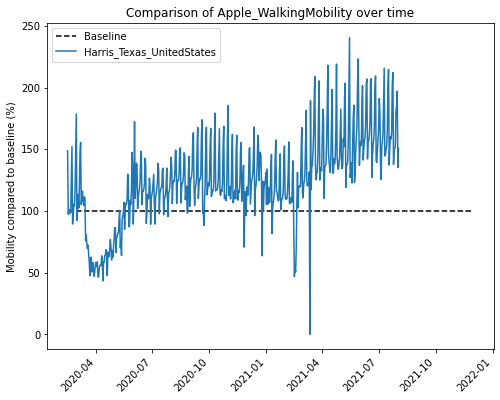

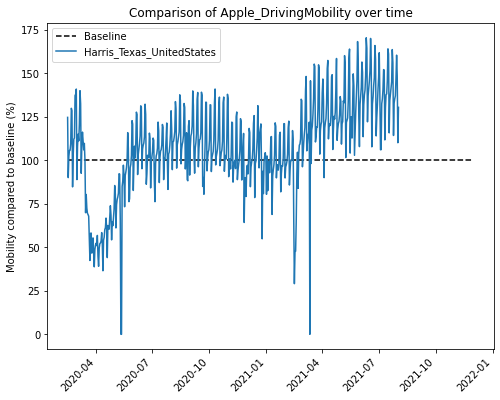

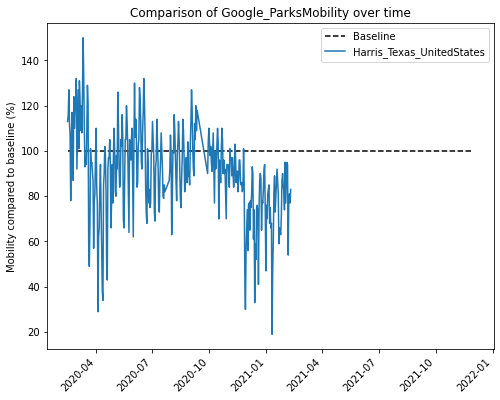

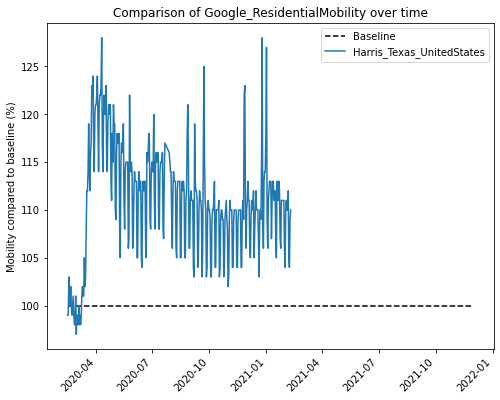

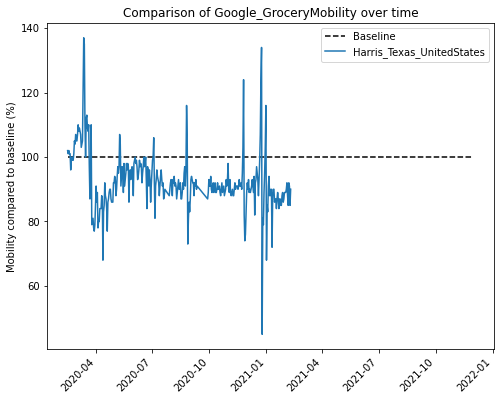

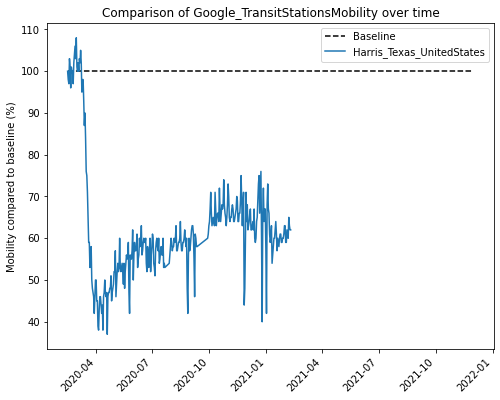

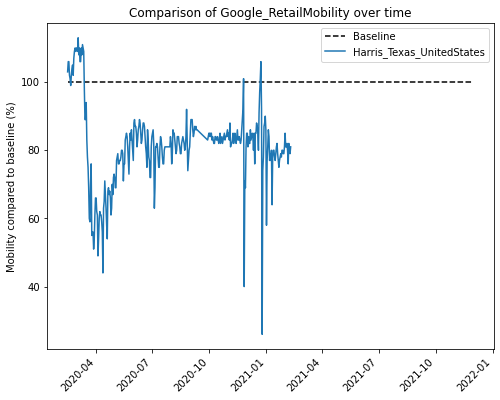

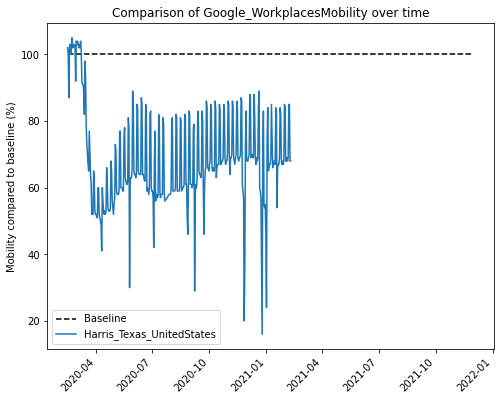

In [342]:
for metric in metrics:
    plt.figure(figsize = (8, 6))

    if "Mobility" in metric:
        plt.plot(
            complete_timeseries["dates"],
            [100 for d in complete_timeseries["dates"]],
            label = "Baseline",
            linestyle = "dashed",
            color = "black"
        )

    for location in locations:
        data_col = location + "." + metric + ".data"
        missing_col = location + "." + metric + ".missing"

        missing = list(complete_timeseries[missing_col])
        data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
        dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

        plt.plot(
            dates,
            data,
            label = location
        )

    plt.legend()
    plt.xticks(rotation = 45, ha = "right")
    if "Mobility" in metric:
        plt.ylabel("Mobility compared to baseline (%)")
    else:
        plt.ylabel("Count")
    plt.title("Comparison of " + metric + " over time")
    plt.show()

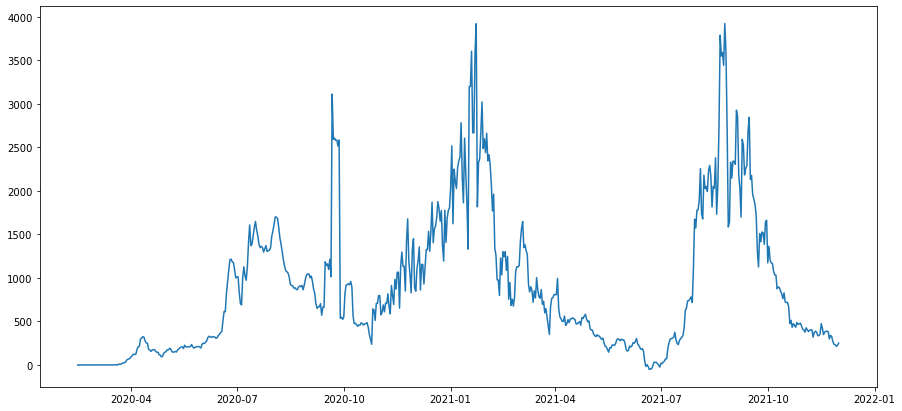

In [343]:
complete_timeseries['confirmed_cases_diff'] = complete_timeseries['Harris_Texas_UnitedStates.JHU_ConfirmedCases.data'].diff().rolling(window=7).mean().round().fillna(0) #moving averages?
plt.plot(complete_timeseries.dates, complete_timeseries['confirmed_cases_diff'])
plt.show()

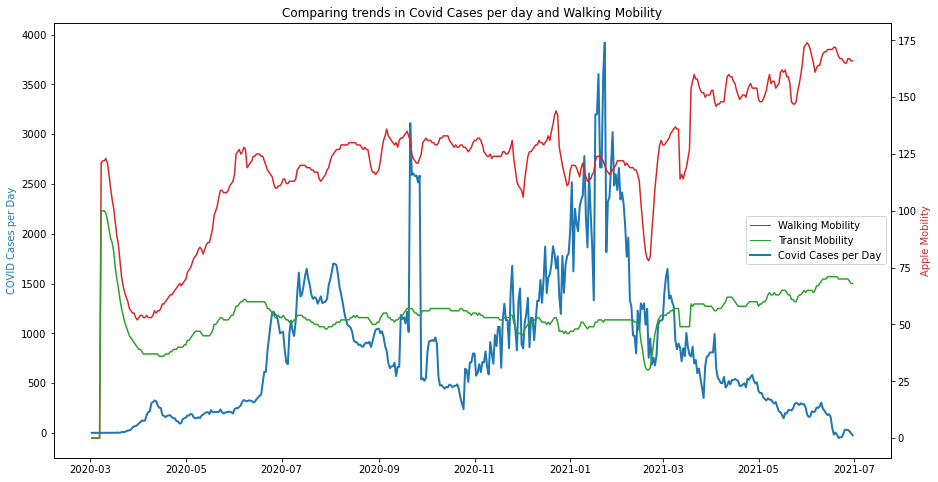

In [344]:
# plt.plot(complete_timeseries.dates, temp)
complete_timeseries = complete_timeseries[(complete_timeseries.dates < '2021-07') & (complete_timeseries.dates > '2020-03')]
temp = complete_timeseries['Harris_Texas_UnitedStates.Apple_WalkingMobility.data'].rolling(window=7).mean().round().fillna(0) #moving averages?
temp2 = complete_timeseries['Harris_Texas_UnitedStates.Apple_TransitMobility.data'].rolling(window=7).mean().round().fillna(0)

fig, ax_left = plt.subplots(figsize = (15, 8))
ax_right = ax_left.twinx()

ax_left.plot(complete_timeseries.dates, complete_timeseries['confirmed_cases_diff'], color='tab:blue', lw=2)
ax_left.set_ylabel("COVID Cases per Day", color='tab:blue')

ax_right.plot(complete_timeseries.dates,temp, color='tab:red')
ax_right.plot(complete_timeseries.dates,temp2, color='tab:green')
ax_right.set_ylabel("Apple Mobility", color='tab:red')

plt.title("Comparing trends in Covid Cases per day and Walking Mobility")

plt.legend([
    Line2D([0], [0], color = "tab:red", linestyle = linestyles[0], lw=1),
    Line2D([0], [0], color = "tab:green", linestyle = linestyles[0], lw=1),
    Line2D([0], [0], color = "tab:blue", linestyle = linestyles[0], lw=2)],
   ['Walking Mobility','Transit Mobility','Covid Cases per Day'], loc=7)

plt.show()

In [345]:
complete_timeseries.columns = ['dates', 'Harris_Texas_UnitedStates.JHU_ConfirmedCases.data',
       'Harris_Texas_UnitedStates.JHU_ConfirmedCases.missing',
       'Harris_Texas_UnitedStates.Apple_WalkingMobility.data',
       'Harris_Texas_UnitedStates.Apple_WalkingMobility.missing',
       'Harris_Texas_UnitedStates.Apple_TransitMobility.data',
       'Harris_Texas_UnitedStates.Apple_TransitMobility.missing',
       'Harris_Texas_UnitedStates.Apple_DrivingMobility.data',
       'Harris_Texas_UnitedStates.Apple_DrivingMobility.missing',
       'Harris_Texas_UnitedStates.Google_ResidentialMobility.data',
       'Harris_Texas_UnitedStates.Google_ResidentialMobility.missing',
       'Harris_Texas_UnitedStates.Google_GroceryMobility.data',
       'Harris_Texas_UnitedStates.Google_GroceryMobility.missing',
       'Harris_Texas_UnitedStates.Google_TransitStationsMobility.data',
       'Harris_Texas_UnitedStates.Google_TransitStationsMobility.missing',
       'Harris_Texas_UnitedStates.Google_ParksMobility.data',
       'Harris_Texas_UnitedStates.Google_ParksMobility.missing',
       'Harris_Texas_UnitedStates.Google_WorkplacesMobility.data',
       'Harris_Texas_UnitedStates.Google_WorkplacesMobility.missing',
       'Harris_Texas_UnitedStates.Google_RetailMobility.data',
       'Harris_Texas_UnitedStates.Google_RetailMobility.missing',
       'confirmed_cases_diff']

In [346]:
complete_timeseries.shape

(486, 22)

In [347]:
final_df = complete_timeseries[complete_timeseries['Harris_Texas_UnitedStates.Google_RetailMobility.missing'] < 100]
final_df.shape

(323, 22)

# Research Question 2

## Is covid transmission related to the different kinds of mobility within the county?

*We have data on Walking, Driving, Parks, Residential, Transit, etc. mobility provided by Google and Apple. Using this data we can plot alongside it our time series on COVID cases from A4. I will aim to find any relationships between this mobility data and COVID cases to see if people moving in/out of the county are affecting the infection rates. FUTURE WORK: It will be interesting to observe the correlation using the ARIMA model because these data are time series.*

In [348]:
google_df = final_df[['dates',
       'Harris_Texas_UnitedStates.Google_ResidentialMobility.data',
       'Harris_Texas_UnitedStates.Google_GroceryMobility.data',
       'Harris_Texas_UnitedStates.Google_TransitStationsMobility.data',
       'Harris_Texas_UnitedStates.Google_ParksMobility.data',
       'Harris_Texas_UnitedStates.Google_WorkplacesMobility.data',
       'Harris_Texas_UnitedStates.Google_RetailMobility.data',
       'confirmed_cases_diff']]
google_df = google_df.reset_index().drop(columns=['index'])

apple_df = final_df[['dates',
       'Harris_Texas_UnitedStates.Apple_WalkingMobility.data',
       'Harris_Texas_UnitedStates.Apple_TransitMobility.data',
       'Harris_Texas_UnitedStates.Apple_DrivingMobility.data',
       'confirmed_cases_diff']]
apple_df = apple_df.reset_index().drop(columns=['index'])

In [349]:
google_df.columns = ['dates',
       'Google_ResidentialMobility',
       'Google_GroceryMobility',
       'Google_TransitStationsMobility',
       'Google_ParksMobility',
       'Google_WorkplacesMobility',
       'Google_RetailMobility',
       'confirmed_cases_diff']

In [350]:
google_df

,dates,Google_ResidentialMobility,Google_GroceryMobility,Google_TransitStationsMobility,Google_ParksMobility,Google_WorkplacesMobility,Google_RetailMobility,confirmed_cases_diff
0,2020-03-02,98.0,107.0,100.0,111.0,104.0,109.0,0.0
1,2020-03-03,98.0,110.0,102.0,127.0,103.0,113.0,0.0
2,2020-03-04,100.0,108.0,100.0,101.0,102.0,108.0,0.0
3,2020-03-05,98.0,109.0,103.0,131.0,103.0,110.0,0.0
4,2020-03-06,99.0,108.0,102.0,123.0,102.0,106.0,0.0
...,...,...,...,...,...,...,...,...
318,2021-02-05,112.0,85.0,60.0,54.0,69.0,76.0,2083.0
319,2021-02-06,105.0,92.0,65.0,79.0,85.0,82.0,1769.0
320,2021-02-07,104.0,91.0,63.0,81.0,85.0,80.0,1961.0
321,2021-02-08,109.0,85.0,62.0,77.0,68.0,79.0,1338.0


In [351]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(google_df.iloc[:,1:])
scaled_df = pd.DataFrame(scaled_df, columns = google_df.columns[1:])

X = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     confirmed_cases_diff   R-squared:                       0.341
Model:                              OLS   Adj. R-squared:                  0.328
Method:                   Least Squares   F-statistic:                     27.21
Date:                  Thu, 09 Dec 2021   Prob (F-statistic):           3.99e-26
Time:                          20:23:31   Log-Likelihood:                -391.06
No. Observations:                   323   AIC:                             796.1
Df Residuals:                       316   BIC:                             822.6
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [352]:
apple_df.columns = ['dates',
       'Apple_WalkingMobility',
       'Apple_TransitMobility',
       'Apple_DrivingMobility',
       'confirmed_cases_diff']

In [353]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(apple_df.iloc[:,1:])
scaled_df = pd.DataFrame(scaled_df, columns = apple_df.columns[1:])

X = scaled_df.iloc[:,:-1]
y = scaled_df.iloc[:,-1]

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                             
Dep. Variable:     confirmed_cases_diff   R-squared:                       0.260
Model:                              OLS   Adj. R-squared:                  0.253
Method:                   Least Squares   F-statistic:                     37.27
Date:                  Thu, 09 Dec 2021   Prob (F-statistic):           1.13e-20
Time:                          20:23:31   Log-Likelihood:                -409.79
No. Observations:                   323   AIC:                             827.6
Df Residuals:                       319   BIC:                             842.7
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const     

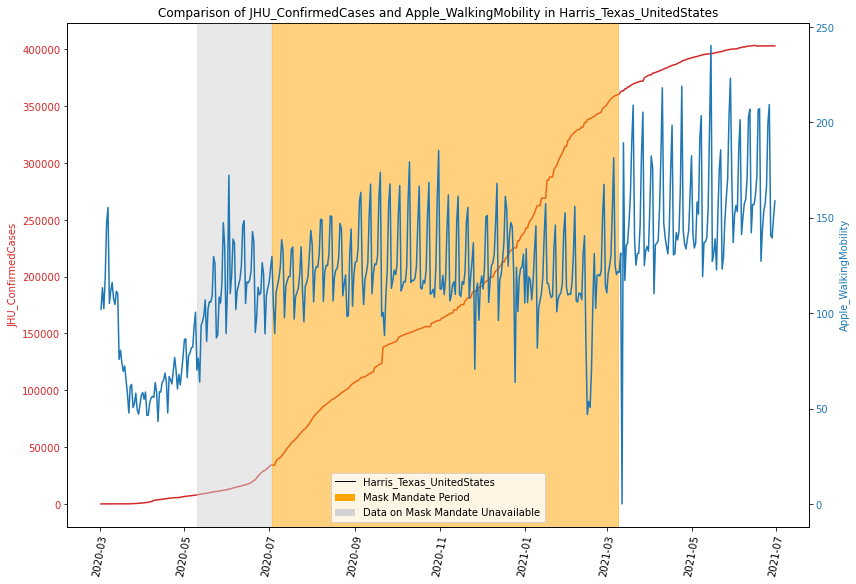

In [375]:
from matplotlib.lines import Line2D

metric1 = "JHU_ConfirmedCases"
metric2 = "Apple_WalkingMobility"

location1 = "Harris_Texas_UnitedStates"
# location2 = "Bexar_Texas_UnitedStates"

all_locations = [location1] #, location2]
linestyles = ["solid", "dashed"]

fig, ax1 = plt.subplots(figsize = (12, 8))
color = 'tab:red'
ax1.set_ylabel(metric1, color = color)
ax1.tick_params(axis='y', labelcolor = color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric1 + ".data"
    missing_col = location + "." + metric1 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax1.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel(metric2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

for i, location in enumerate(all_locations):
    data_col = location + "." + metric2 + ".data"
    missing_col = location + "." + metric2 + ".missing"

    missing = list(complete_timeseries[missing_col])
    data = [list(complete_timeseries[data_col])[i] for i in range(len(complete_timeseries[data_col])) if missing[i] < 100]
    dates = [list(complete_timeseries["dates"])[i] for i in range(len(complete_timeseries["dates"])) if missing[i] < 100]

    ax2.plot(
        dates,
        data,
        ls = linestyles[i],
        color = color,
        label = location
    )
    


plt.legend([
    Line2D([0], [0], color = "black", linestyle = linestyles[0], lw=1),
    Patch(facecolor='orange'),
    Patch(facecolor='lightgray')], 
    all_locations+['Mask Mandate Period', 'Data on Mask Mandate Unavailable'])

ax1.tick_params(axis='x', labelrotation = 80)

fig.tight_layout()
plt.title("Comparison of " + metric1 + " and " + metric2 + " in " + location1)


plt.axvspan("2020-05-10", '2020-07-02', color='lightgray', alpha=0.5)
plt.axvspan('2020-07-03', '2021-03-09', color='orange', alpha=0.5)

legend_elements = [Patch(facecolor='orange',
                         label='Mask Mandate Period'),
                  Patch(facecolor='lightgray',
                         label='Data on Mask Mandate Unavailable')]

plt.show()